In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

In [9]:
epochs=20
batch_size=50
input_shape=(28,28,1)
latent_dim=2
h_image,w_image=28,28

In [10]:
(X_train,y_train) , (X_test,y_test) = tf.keras.datasets.mnist.load_data()
X_train=X_train.reshape(60000,28,28,1).astype('float32')/255.0
X_test=X_test.reshape(10000,28,28,1).astype('float32')/255.0
y_train=y_train.astype('int32')
y_test=y_test.astype('int32')

11493376/11490434 [==============================] - 0s 0us/step


In [11]:
train_dataset=tf.data.Dataset.from_tensor_slices((X_train,y_train)).\
batch(batch_size).repeat()

test_dataset=tf.data.Dataset.from_tensor_slices((X_test,y_test)).\
batch(batch_size).repeat()

In [12]:
def conv_layer(layer,filters,
               kernel,activation='relu',
               padding='same',strides=1):
  return tf.keras.layers.Conv2D(filters=filters,
                         kernel_size=kernel,
                         strides=strides,
                         activation=activation,
                         padding=padding)(layer)
  
def conv_transpose_layer(layer,filters,
               kernel,activation='relu',
               padding='same',strides=1):
  return tf.keras.layers.Conv2DTranspose(filters=filters,
                         kernel_size=kernel,
                         strides=strides,
                         activation=activation,
                         padding=padding)(layer)
  

def model(input_shape,latent_dim):
  #Encoder 
  model_input=tf.keras.Input(input_shape)
  layer=conv_layer(model_input,32,3)
  layer=conv_layer(layer,16,3,strides=2)
  layer=conv_layer(layer,32,3,strides=2)
  shape_before_flatten=layer.shape
  layer=tf.keras.layers.Flatten()(layer)
  mean=tf.keras.layers.Dense(latent_dim)(layer)
  var=tf.keras.layers.Dense(latent_dim)(layer)
  encoder_model=tf.keras.models.Model(model_input,[mean,var])
  
  #Decoder
  decoder_input=tf.keras.Input((latent_dim,))
  layer=tf.keras.layers.Dense(np.prod(shape_before_flatten[1:]),\
                              activation='relu')(decoder_input)
  layer=tf.keras.layers.Reshape(target_shape=shape_before_flatten[1:])(layer)
  layer=conv_transpose_layer(layer,32,3,strides=2)
  layer=conv_transpose_layer(layer,16,3,strides=2)
  layer=conv_transpose_layer(layer,1,3,activation='sigmoid')
  decoder_model=tf.keras.models.Model(decoder_input,layer)  
 
  #Reparameterization Trick
  mean,var=encoder_model(model_input)
  epsilon=tf.random.normal(shape=(tf.shape(var)[0],
                                  tf.shape(var)[1]))
  z=mean+tf.exp(var)*epsilon
  model_out=decoder_model(z)
  model=tf.keras.models.Model(model_input,model_out)

  #Reconstruction loss
  reconstruction_loss = K.sum(K.binary_crossentropy(model_input,
                                                    model_out), axis=[1, 2, 3])
  
  #KL div loss
  kl_loss = - 0.5 * K.sum(1 + var - K.square(mean) - K.exp(var), axis=-1)
  
  elbo = K.mean(reconstruction_loss + kl_loss)
  model.add_loss(elbo)
  return model,decoder_model,encoder_model

In [13]:
vae_model,decoder_model,encoder_model=model(input_shape,latent_dim)

vae_model.compile(optimizer=tf.keras.optimizers.Adam(0.01))

callback=[(tf.keras.callbacks.ModelCheckpoint(filepath='/sample_data/mnist_model.h5',
                                            patience=0, verbose=0))]
vae_model.fit(train_dataset,epochs=epochs,callbacks=callback,
              steps_per_epoch=(len(X_train)//batch_size))

Epoch 1/20
1200/1200 [==============================] - 91s 76ms/step - loss: 180.5583
Epoch 2/20
1200/1200 [==============================] - 92s 77ms/step - loss: 166.2029
Epoch 3/20
1200/1200 [==============================] - 92s 76ms/step - loss: 164.1510
Epoch 4/20
1200/1200 [==============================] - 91s 76ms/step - loss: 163.1505
Epoch 5/20
1200/1200 [==============================] - 95s 79ms/step - loss: 162.6637
Epoch 6/20
1200/1200 [==============================] - 93s 77ms/step - loss: 162.2181
Epoch 7/20
1200/1200 [==============================] - 93s 78ms/step - loss: 162.0096
Epoch 8/20
1200/1200 [==============================] - 92s 76ms/step - loss: 161.5253
Epoch 9/20
1200/1200 [==============================] - 91s 76ms/step - loss: 161.3006
Epoch 10/20
1200/1200 [==============================] - 90s 75ms/step - loss: 160.9966
Epoch 11/20
1200/1200 [==============================] - 91s 75ms/step - loss: 160.7725
Epoch 12/20
1200/1200 [==================

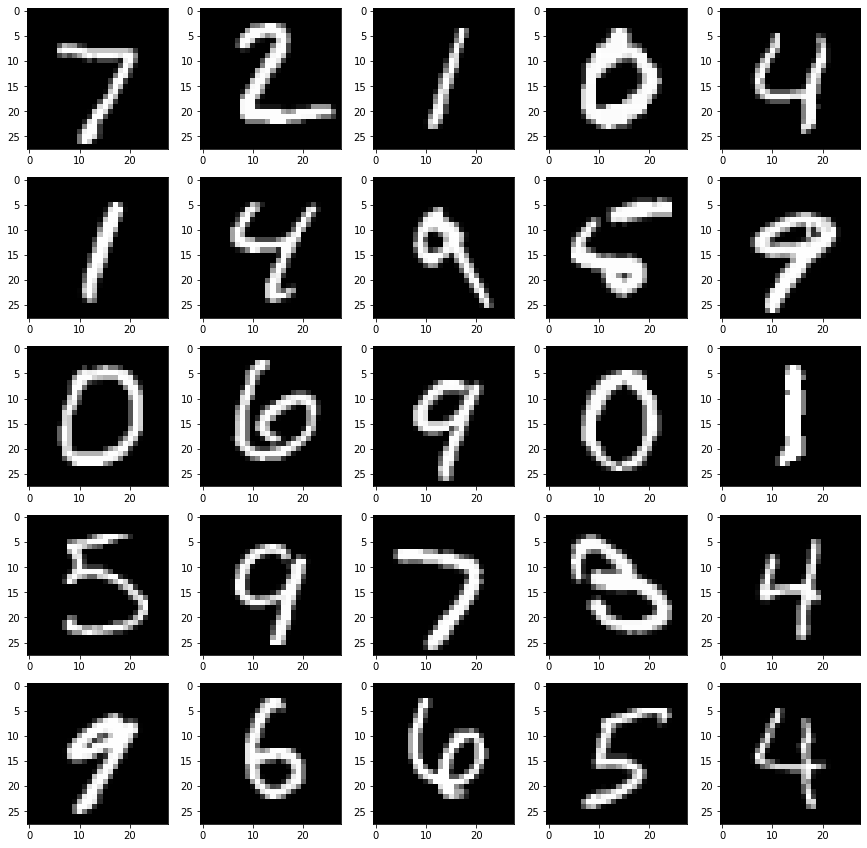

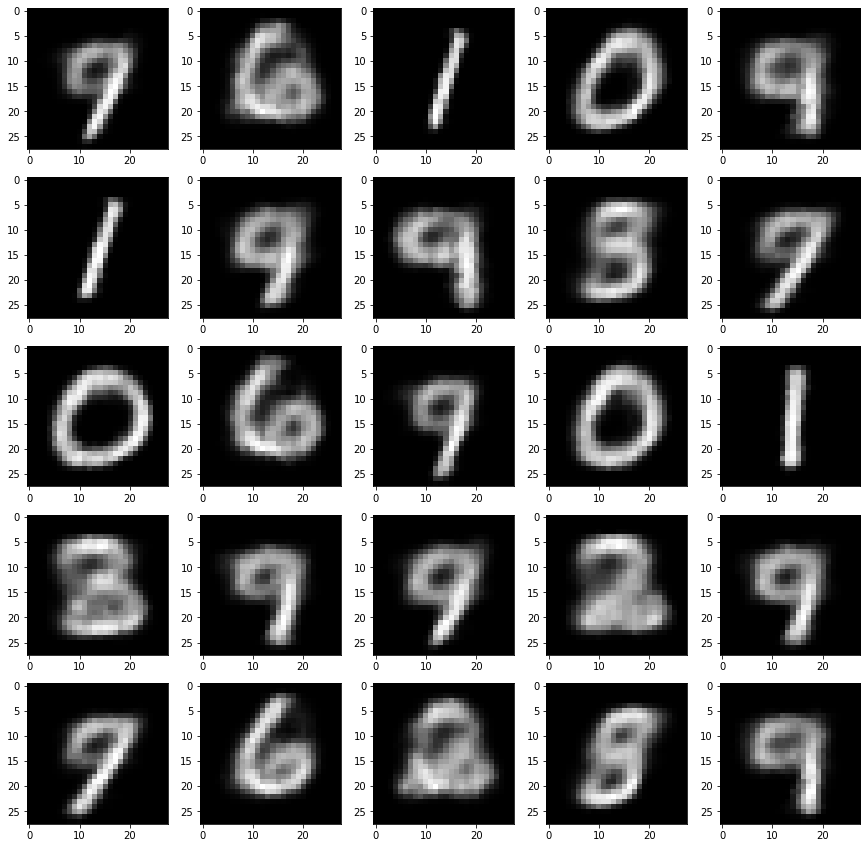

In [21]:
#Testing using decoder

#Image generated 
plt.figure(figsize=(15,15))
img_size=(h_image,w_image)

for i in range(25):
   for val in test_dataset.take(1):
     plt.subplot(5,5,i+1)
     plt.imshow(tf.reshape(val[0][i],img_size),cmap='gray')
plt.show()

plt.figure(figsize=(15,15))
for i in range(25):
  for val in test_dataset.take(1):
    z=encoder_model.predict(np.expand_dims(val[0][i],axis=0))
    output=decoder_model.predict(z)
    output=tf.reshape(output,img_size)
    plt.subplot(5,5,i+1)
    plt.imshow(output,cmap='gray')
plt.show()

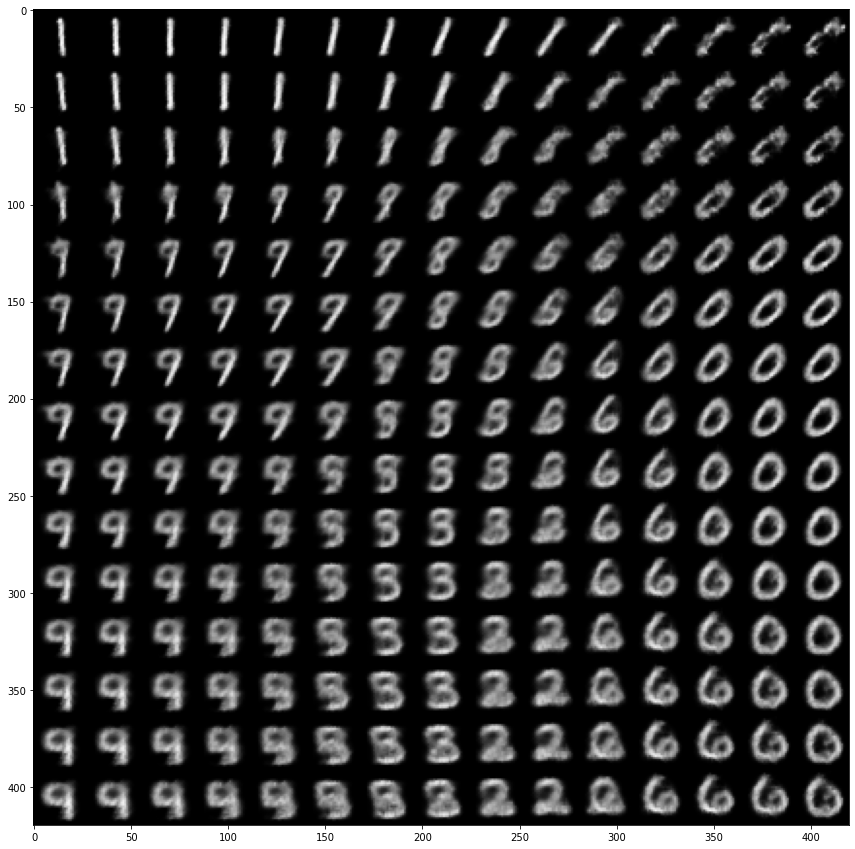

In [22]:
#Uniformally generated Data

plt.figure(figsize=(15,15))
size = 28
n = 15

save_images = np.zeros((size * n, size * n))

grid_x = tf.linspace(-1.5, 1.5, n)
grid_y = tf.linspace(-1.5, 1.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        img = decoder_model(z_sample)
        img = tf.reshape(img[0],img_size)
        save_images[i * size: (i + 1) * size, j * size: (j + 1) * size] = img

plt.imshow(save_images, cmap='gray')
plt.show()

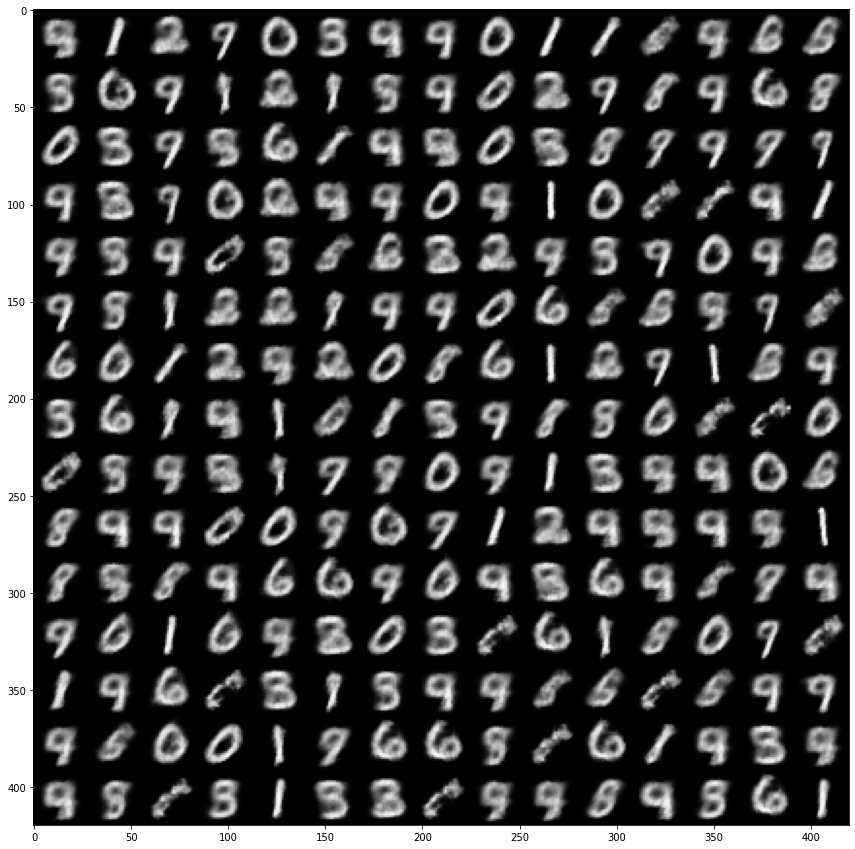

In [16]:
#Randomly Generated Data
n = 15
size = 28
save_images = np.zeros((size * n, size * n))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1.5, 1.5,size=latent_dim)])
        x_decoded = decoder_model.predict(z_sample)
        img = tf.reshape(x_decoded[0],img_size)
        save_images[i * size: (i + 1) * size,j * size: (j + 1) * size] = img

plt.figure(figsize=(15, 15))
plt.imshow(save_images, cmap='Greys_r')
plt.show()

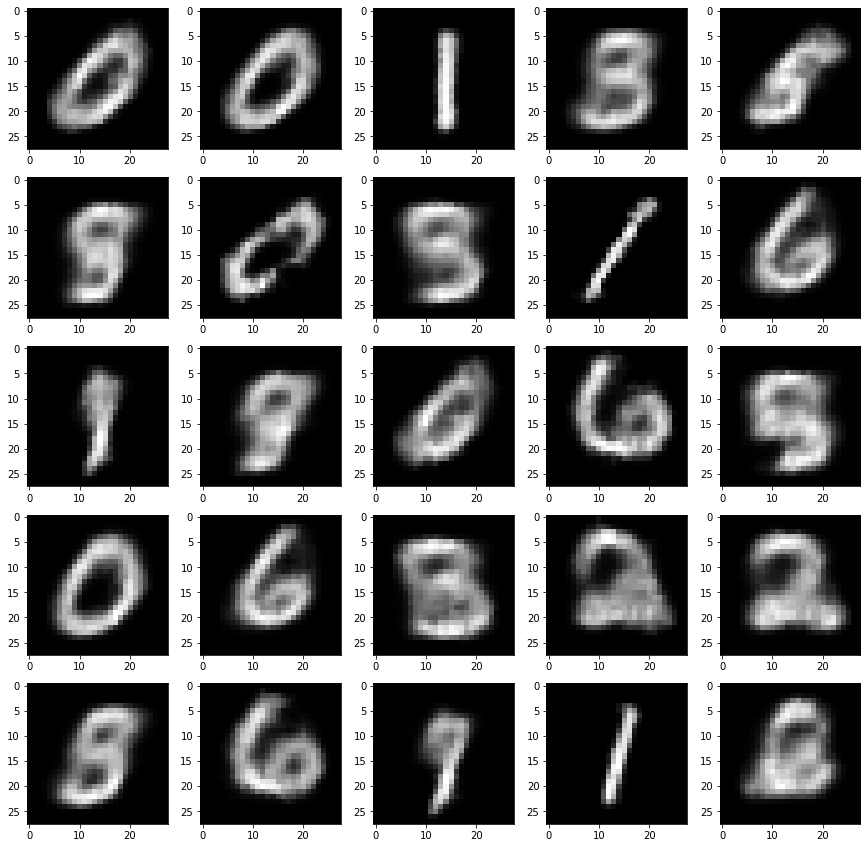

In [24]:
#Random Image generated
num_example=1
plt.figure(figsize=(15,15))
for i in range(25):
  plt.subplot(5,5,i+1)
  test_example=tf.random.normal(shape=[num_example,latent_dim])
  pred=decoder_model.predict(test_example)
  plt.imshow(tf.reshape(pred,(h_image,w_image)),cmap='gray')
plt.show()